# Parkinson's Detection with SPIRAL Diagram

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten, Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [2]:
# os.chdir('/content/drive/MyDrive/project')

In [3]:
! ls

100_spiral_model.h5            spiral_final_model.ipynb
FINAL_MODEL.ipynb              spiral_healthy_augumentor.py
Original_data                  spiral_parkinson_augumentor.py
Wave_Final_Model.ipynb         wave
models                         wave_basic_model.ipynb
spiral                         wave_healthy_augumentor.py
spiral_basic_model.ipynb       wave_parkinson_augumentor.py


In [4]:
plt.style.use('dark_background')

In [5]:
cur_dir = os.getcwd()

healthy_path = os.path.join(cur_dir, 'spiral/healthy')
parkinson_path = os.path.join(cur_dir, 'spiral/parkinson')


# Data Visulization

### Healthy Wave

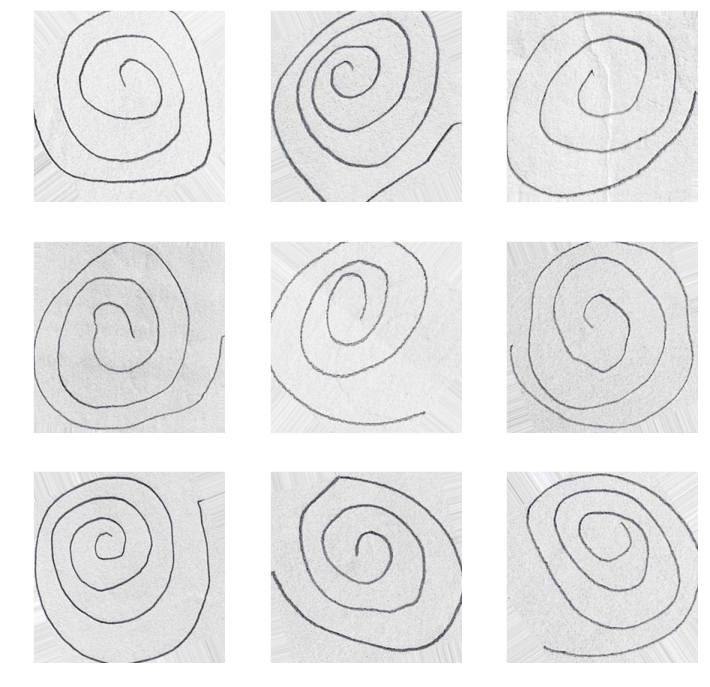

In [6]:
plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    name = os.listdir(healthy_path)[i]
    img_path = os.path.join(healthy_path, name)
    img = load_img(img_path)
    plt.imshow(img)   
plt.show() 

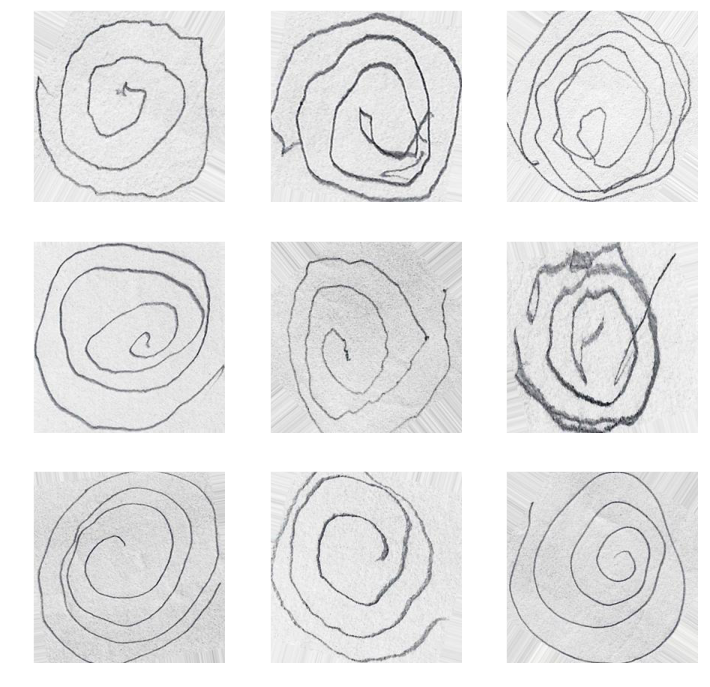

In [7]:
plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    name = os.listdir(parkinson_path)[i]
    img_path = os.path.join(parkinson_path, name)
    img = load_img(img_path)
    plt.imshow(img)   
plt.show() 

## Loading Data

In [8]:
data = tf.keras.utils.image_dataset_from_directory('spiral')

Found 5089 files belonging to 2 classes.


2022-06-24 14:16:49.357913: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
data_iterator = data.as_numpy_iterator()

In [10]:
batch = data_iterator.next()

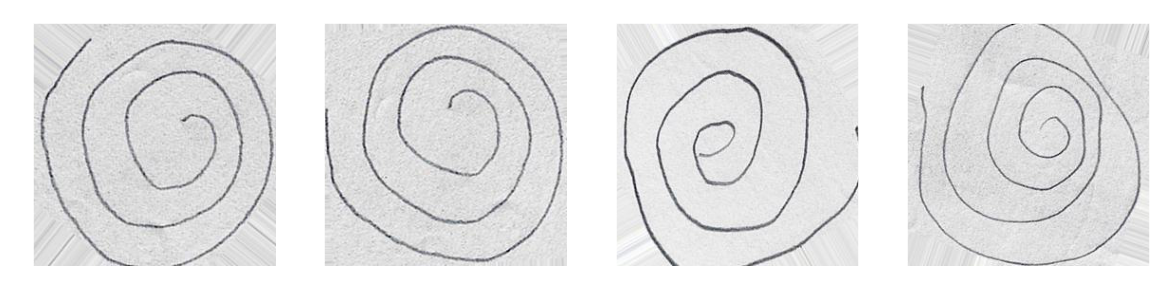

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Converting pixel between 0 to 1

In [12]:
data = data.map(lambda x,y: (x/255, y))

In [13]:
data.as_numpy_iterator().next()

(array([[[[0.8784314 , 0.8784314 , 0.8784314 ],
          [0.8784314 , 0.8784314 , 0.8784314 ],
          [0.8784314 , 0.8784314 , 0.8784314 ],
          ...,
          [0.8980392 , 0.8980392 , 0.8980392 ],
          [0.9019608 , 0.9019608 , 0.9019608 ],
          [0.89411765, 0.89411765, 0.89411765]],
 
         [[0.89411765, 0.89411765, 0.89411765],
          [0.8901961 , 0.8901961 , 0.8901961 ],
          [0.8901961 , 0.8901961 , 0.8901961 ],
          ...,
          [0.8980392 , 0.8980392 , 0.8980392 ],
          [0.9019608 , 0.9019608 , 0.9019608 ],
          [0.89411765, 0.89411765, 0.89411765]],
 
         [[0.9098039 , 0.9098039 , 0.9098039 ],
          [0.9098039 , 0.9098039 , 0.9098039 ],
          [0.90588236, 0.90588236, 0.90588236],
          ...,
          [0.9019608 , 0.9019608 , 0.9019608 ],
          [0.9019608 , 0.9019608 , 0.9019608 ],
          [0.8901961 , 0.8901961 , 0.8901961 ]],
 
         ...,
 
         [[0.91764706, 0.91764706, 0.91764706],
          [0.90588

## Splitting Data

In [14]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [15]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Building the MODEL

In [26]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

In [27]:
logdir='logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [tensorboard_callback,reduce_learningrate]

In [28]:
model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate=0.001), metrics=['accuracy'])

In [29]:
history = model.fit(
        train,
        epochs = 101,
        validation_data = val,
        callbacks=reduce_learningrate)

Epoch 1/101
112/112 [==============================] - 678s 6s/step - loss: 0.7375 - accuracy: 0.5006 - val_loss: 0.6925 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/101
112/112 [==============================] - 18s 155ms/step - loss: 0.6196 - accuracy: 0.6476 - val_loss: 0.5511 - val_accuracy: 0.6826 - lr: 0.0010
Epoch 3/101
112/112 [==============================] - 18s 157ms/step - loss: 0.4076 - accuracy: 0.8108 - val_loss: 0.3271 - val_accuracy: 0.8604 - lr: 0.0010
Epoch 4/101
112/112 [==============================] - 18s 160ms/step - loss: 0.2199 - accuracy: 0.9082 - val_loss: 0.1661 - val_accuracy: 0.9346 - lr: 0.0010
Epoch 5/101
112/112 [==============================] - 19s 166ms/step - loss: 0.1017 - accuracy: 0.9632 - val_loss: 0.0631 - val_accuracy: 0.9795 - lr: 0.0010
Epoch 6/101
112/112 [==============================] - 18s 158ms/step - loss: 0.0370 - accuracy: 0.9874 - val_loss: 0.1053 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 7/101
112/112 [===========================

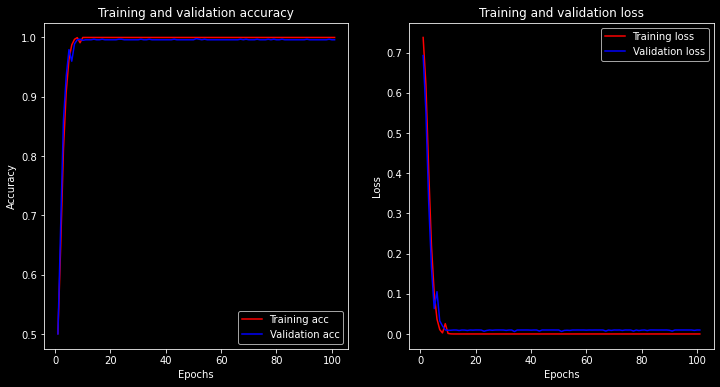

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc', color = 'red')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
 
    
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label='Training loss', color = 'red')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Model Evaluate

In [31]:
pre = Precision()    # ( TP / TP + FP )
re = Recall()       # Recall ( TP / TP + FN )
acc = BinaryAccuracy()  

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# Explanation 

---> Precision = 1 : none of the positive samples are classified incorrectly.
---
---> Recall = 1 : every result retrieved by a search was relevant
---
---> Binary Accuracy = 1 : prediction is perfect
------------------------------

## Testing 

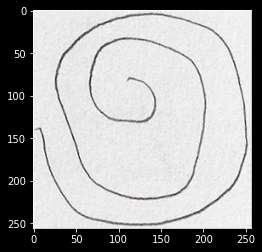

In [32]:
img_path = os.path.join(cur_dir, 'spiral/healthy/healthy_V01HE01_0_1119.jpg')

img = cv2.imread(img_path)
plt.imshow(img)
plt.show()

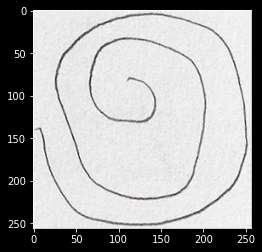

In [33]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [34]:
prediction = model.predict(np.expand_dims(resize/255, 0))

print(prediction)

[[7.730823e-08]]


### Key 
 
### 0 --> Healthy
### 1 --> Parkinson

In [35]:
if prediction < 0.5: 
    print(f'The person is Healthy')
else:
    print(f'The person may have parkinson')

The person is Healthy


## Saving the MODEL


In [16]:
from tensorflow.keras.models import load_model

# model.save('100_spiral_model.h5')  # USE THIS TO SAVE MODEL
model = load_model('100_spiral_model.h5')

## Training vs Testing 

In [18]:
loss, accuracy = model.evaluate(train, verbose=1)

112/112 [==============================] - 44s 395ms/step - loss: 0.0026 - accuracy: 0.9992


In [19]:
print(f'Training Accuracy = {accuracy*100}')

Training Accuracy = 99.91629719734192


In [20]:
loss, accuracy = model.evaluate(test, verbose=1)

16/16 [==============================] - 7s 369ms/step - loss: 5.2437e-04 - accuracy: 1.0000


In [21]:
print(f'Training Accuracy = {accuracy*100}')

Training Accuracy = 100.0


## Testing 

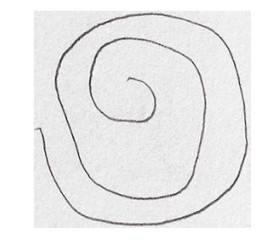

In [43]:
img_path = os.path.join(cur_dir, 'spiral/healthy/healthy_V01HE01_0_1119.jpg')

img = cv2.imread(img_path)
plt.imshow(img)
plt.show()

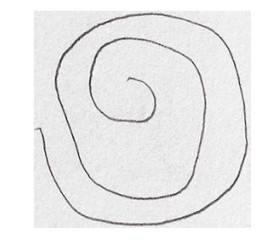

In [44]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [50]:
prediction = new_model.predict(np.expand_dims(resize/255, 0))

print(prediction)

[[7.686582e-08]]


In [49]:
if prediction < 0.5: 
    print(f'The person is Healthy')
else:
    print(f'The person may have parkinson')

The person is Healthy


### Test 2

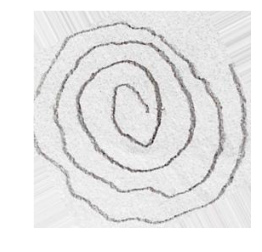

In [37]:
img_path = os.path.join(cur_dir, 'spiral/parkinson/parkinson_V02PE02_0_120.jpg')

img = cv2.imread(img_path)
plt.imshow(img)
plt.show()

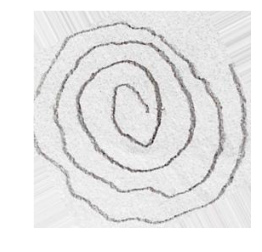

In [38]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [41]:
prediction = new_model.predict(np.expand_dims(resize/255, 0))
print(prediction)

[[1.]]


In [42]:
if prediction < 0.5: 
    print(f'The person is Healthy')
else:
    print(f'The person may have parkinson')

The person may have parkinson


## Testing on Original Data

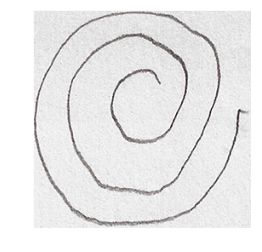

In [52]:
img_path = os.path.join(cur_dir, 'Original_data/spiral/healthy/V01HE03.png')

img = cv2.imread(img_path)
plt.imshow(img)
plt.show()

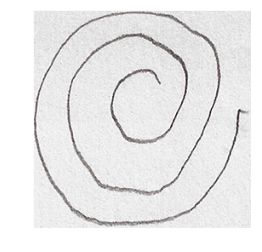

In [53]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [54]:
prediction = new_model.predict(np.expand_dims(resize/255, 0))
print(prediction)

[[3.8754963e-18]]


In [55]:
if prediction < 0.5: 
    print(f'The person is Healthy')
else:
    print(f'The person may have parkinson')

The person is Healthy


### Test 2

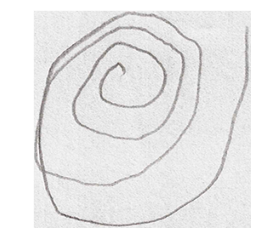

In [56]:
img_path = os.path.join(cur_dir, 'Original_data/spiral/parkinson/V01PE03.png')

img = cv2.imread(img_path)
plt.imshow(img)
plt.show()

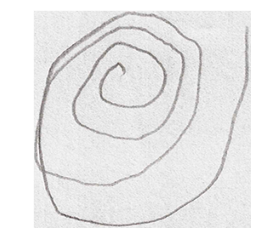

In [57]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [58]:
prediction = new_model.predict(np.expand_dims(resize/255, 0))
print(prediction)

[[0.9992367]]


In [59]:
if prediction < 0.5: 
    print(f'The person is Healthy')
else:
    print(f'The person may have parkinson')

The person may have parkinson
